# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
# remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:40<00:00, 2147.00it/s]


In [23]:
preprocessed_reviews[100]

'frenchbull given nylabone chew since weeks old safe strong bite not break large pieces could choke dinosaur chew perfect many places hold bite dylabone product buy'

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
from sklearn.model_selection import train_test_split

print(type(final['Text']))
final['Text'] = preprocessed_reviews

# Created new feature TextLength (Length of Review) in our preprocessed data
final['TextLength'] = final['Text'].str.len()

X = final
Y = final['Score'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) 

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

<class 'pandas.core.series.Series'>
(61441, 11) (61441,)
(26332, 11) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
from scipy.sparse import hstack

count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train['Text'])
# print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train['Text'])
X_test_bow = count_vect.transform(X_test['Text'])

# Adding new feature Review Length to our featurized train and test data
X_train_bow=hstack([X_train_bow,np.matrix(X_train['TextLength'].values).reshape(X_train.shape[0],1)])
X_test_bow=hstack([X_test_bow,np.matrix(X_test['TextLength'].values).reshape(X_test.shape[0],1)])

# Adding new feature Review Length to list of features
feature_bow = count_vect.get_feature_names()
feature_bow.append('TextLength')

print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text BOW vectorizer  (61441, 46377)
the number of unique words  46377


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train['Text'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train['Text'])
X_test_tfidf = tf_idf_vect.transform(X_test['Text'])

# Adding new feature Review Length to our featurized train and test data
X_train_tfidf=hstack([X_train_tfidf,np.matrix(X_train['TextLength'].values).reshape(X_train.shape[0],1)])
X_test_tfidf=hstack([X_test_tfidf,np.matrix(X_test['TextLength'].values).reshape(X_test.shape[0],1)])

# Adding new feature Review Length to list of features
feature_tfidf = tf_idf_vect.get_feature_names()
feature_tfidf.append('TextLength')

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of TFIDF vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abandoned', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy']
the type of TFIDF vectorizer  <class 'scipy.sparse.coo.coo_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36275)
the number of unique words including both unigrams and bigrams  36275


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus 
list_of_sentance_train=[]
for sentance in X_train['Text']:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=2)

In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14776
sample words  ['water', 'great', 'prefer', 'normal', 'flavor', 'passion', 'fruit', 'version', 'good', 'stuff', 'workout', 'bike', 'ride', 'also', 'prevent', 'hangover', 'one', 'conclude', 'consumption', 'another', 'wake', 'seems', 'replenish', 'necessary', 'minerals', 'etc', 'give', 'pleasant', 'recovery', 'packaging', 'boxes', 'simple', 'open', 'stay', 'cold', 'long', 'time', 'drawback', 'price', 'like', 'said', 'icing', 'happy', 'able', 'buy', 'online', 'family', 'favorite', 'shipped', 'arrived']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
# average Word2Vec
# compute average word2vec for each review.
def avgw2v(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [31]:
sent_vectors_train = avgw2v(list_of_sentance_train)
print(len(sent_vectors_train[0]))
print(len(list_of_sentance_train))

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [02:20<00:00, 436.41it/s]


50
61441


In [32]:
list_of_sentance_test=[]
for sentance in X_test['Text']:
    list_of_sentance_test.append(sentance.split())

sent_vectors_test = avgw2v(list_of_sentance_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:03<00:00, 416.22it/s]


26332
50


#### [4.4.1.2] TFIDF weighted W2v

In [33]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
def tfidfw2v(list_of_sentance):
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [35]:
tfidf_sent_vectors_train = tfidfw2v(list_of_sentance_train)

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [31:13<00:00, 23.23it/s]


In [36]:
tfidf_sent_vectors_test = tfidfw2v(list_of_sentance_test)

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [13:02<00:00, 25.65it/s]


# [5] Assignment 9: Random Forests

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [37]:
%config IPCompleter.greedy=True
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix
import seaborn as sns
# plot 3D Plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

In [ ]:
# Plot 3rd graph for hyperparameters and AUC of train and test results
def D3_Plot(max_depth, base_learners, train_auc, test_auc):

    # https://plot.ly/python/3d-axes/
    train = go.Scatter3d(x=max_depth,y=base_learners,z=train_auc, name = 'train')
    test = go.Scatter3d(x=max_depth,y=base_learners,z=test_auc, name = 'Cross validation')
    data = [train, test]

    layout = go.Layout(scene = dict(
            xaxis = dict(title='Max Depth'),
            yaxis = dict(title='Base_Learners'),
            zaxis = dict(title='AUC'),))

    fig = go.Figure(data=data, layout=layout)
    offline.iplot(fig, filename='3d-scatter-colorscale')

In [ ]:
def Get_Hyperparameters(X_train_vector):
    max_depth =  [5, 10, 15, 20, 25, 30, 35]
    base_learners =  [50, 100, 150, 200, 250, 300, 350]
    parameters = { 'max_depth' : max_depth, 'n_estimators' : base_learners} 

    clf = RandomForestClassifier(random_state=0, n_jobs=-1)
    grid = GridSearchCV(clf, parameters, cv = 10, scoring='roc_auc')
    grid.fit(X_train_vector, Y_train)

    print("Best Estimator: ", grid.best_estimator_)
    print("Best param: ", grid.best_params_)
    print("Best Score: ", grid.best_score_)

    best_depth = grid.best_params_['max_depth']
    best_base_learner = grid.best_params_['n_estimators']
    
    train_auc= grid.cv_results_['mean_train_score']
    cv_auc = grid.cv_results_['mean_test_score']

    # Plot 3rd graph for hyperparameters and AUC of train and test results
    D3_Plot(max_depth, base_learners, train_auc, cv_auc)
    
    # Transform CV results(list of 100) to 10X10
    test_score = cv_auc.reshape(len(base_learners), len(max_depth))

    plt.figure(figsize=(7,7))
    sns.heatmap(test_score, annot=True, fmt=".3f", xticklabels=base_learners, yticklabels=max_depth)
    plt.xlabel("n_estimators")
    plt.ylabel("Depth")
    plt.title("Cross Validation Result")
    plt.show()
    return best_depth, best_base_learner

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best param:  {'max_depth': 35, 'n_estimators': 350}
Best Score:  0.9075509049081137


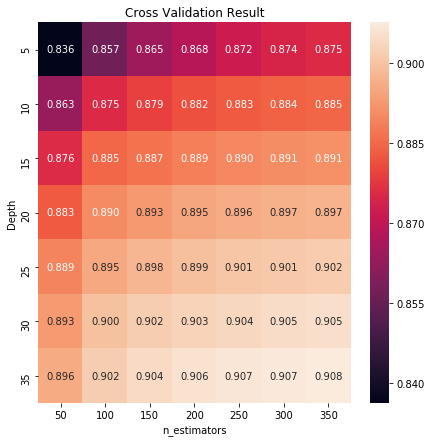

In [ ]:
best_max_depth_bow, best_base_learner_bow  = Get_Hyperparameters(X_train_bow)

In [ ]:
def RandomForest_Test(X_train_vector, X_test_vector, best_depth, best_base_learner):

    clf = RandomForestClassifier(n_estimators = best_base_learner, max_depth=best_depth, random_state=0, n_jobs=-1)
    clf.fit(X_train_vector, Y_train)
    
    train_fpr, train_tpr, threshold = roc_curve(Y_train, clf.predict_log_proba(X_train_vector)[:,1])
    test_fpr, test_tpr, threshold = roc_curve(Y_test, clf.predict_log_proba(X_test_vector)[:,1])
    
    test_auc=auc(test_fpr,test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC: "+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC: "+str(test_auc))
    
    plt.legend()
    plt.xlabel("Hyperparameter")
    plt.ylabel("AUC")
    plt.title("Error Plot")
    plt.show()
    
    # Confusion Matrix of Training data
    class_labels = ['Negative', 'Positive']
    df_cm_train = pd.DataFrame(confusion_matrix(Y_train, clf.predict(X_train_vector)), index=class_labels , columns=class_labels)
    sns.heatmap(df_cm_train, annot=True, fmt="d")
    plt.title("Confusion Matrix of Training data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Confusion Matrix of Test data
    df_cm_test = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test_vector)), index=class_labels , columns=class_labels)
    sns.heatmap(df_cm_test, annot=True, fmt="d")
    plt.title("Confusion Matrix of Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return test_auc, clf

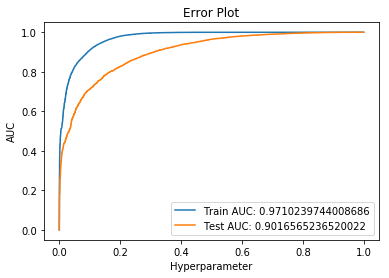

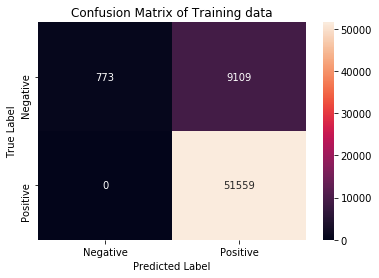

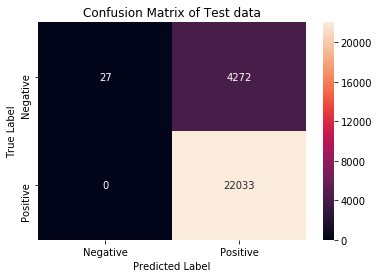

In [ ]:
test_auc_bow, clf_bow = RandomForest_Test(X_train_bow, X_test_bow, 
                                          best_max_depth_bow, best_base_learner_bow)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

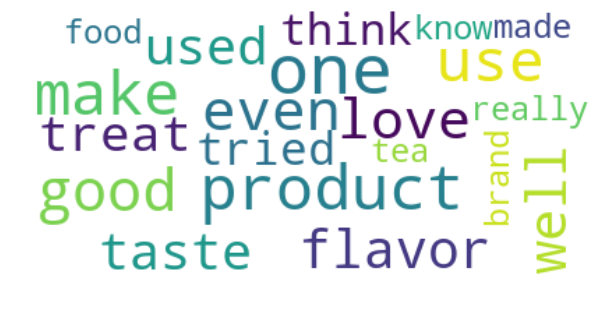

Top Features
0.0217	not
0.0144	disappointed
0.0138	great
0.0119	waste
0.0110	bad
0.0105	horrible
0.0089	awful
0.0087	threw
0.0086	return
0.0085	worst
0.0082	terrible
0.0079	money
0.0065	love
0.0062	would
0.0062	stale
0.0060	disappointing
0.0059	delicious
0.0057	refund
0.0057	disgusting
0.0055	best


In [ ]:
from wordcloud import WordCloud

reviews = ' '.join(preprocessed_reviews)
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(reviews)
wordcloud.to_file("first_wordCloud.png")
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

features = count_vect.get_feature_names()
coefs = sorted(zip(clf_bow.feature_importances_, features))
n =20
top = coefs[:-(n+1):-1]

print("Top Features")
for (coef, feat) in top:
    print("%.4f\t%s" % (coef, feat))

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best param:  {'max_depth': 35, 'n_estimators': 350}
Best Score:  0.9217492517636897


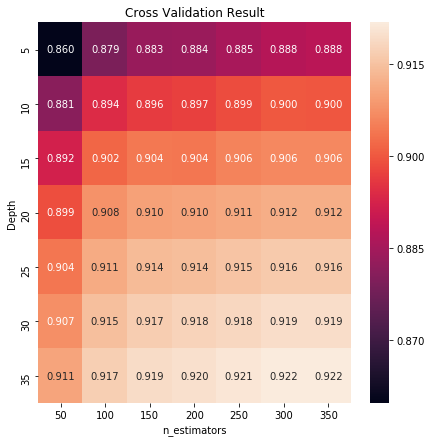

In [ ]:
best_max_depth_tfidf, best_base_learner_tfidf = Get_Hyperparameters(X_train_tfidf)

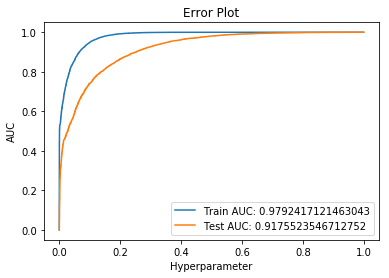

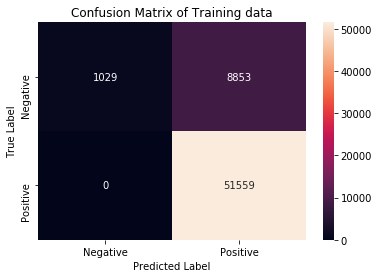

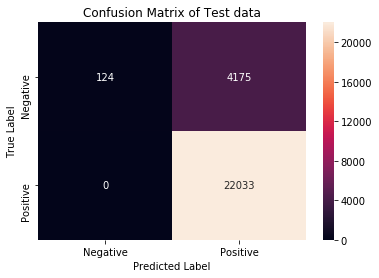

In [ ]:
test_auc_tfidf, clf_tfidf = RandomForest_Test(X_train_tfidf, X_test_tfidf, 
                                              best_max_depth_tfidf, best_base_learner_tfidf)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

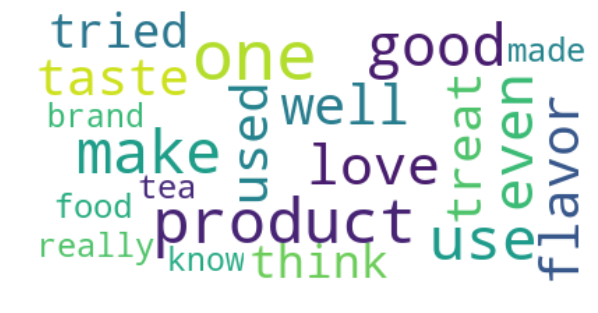

Top Features
0.0208	not
0.0130	great
0.0110	not buy
0.0107	worst
0.0104	disappointed
0.0100	horrible
0.0098	bad
0.0095	return
0.0090	waste money
0.0088	waste
0.0088	money
0.0083	awful
0.0080	not worth
0.0076	threw
0.0068	would not
0.0067	terrible
0.0064	disappointing
0.0058	stale
0.0057	not recommend
0.0056	thought


In [ ]:
reviews = ' '.join(preprocessed_reviews)
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(reviews)
wordcloud.to_file("first_wordCloud.png")
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

features = tf_idf_vect.get_feature_names()
coefs = sorted(zip(clf_tfidf.feature_importances_, features))
n =20
top = coefs[:-(n+1):-1]

print("Top Features")
for (coef, feat) in top:
    print("%.4f\t%s" % (coef, feat))

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best param:  {'max_depth': 30, 'n_estimators': 350}
Best Score:  0.8996990709338865


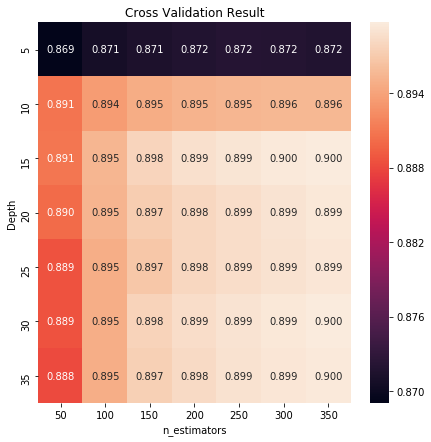

In [ ]:
best_max_depth_avgw2v, best_base_learner_avgw2v = Get_Hyperparameters(sent_vectors_train)

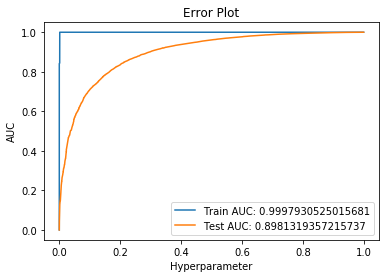

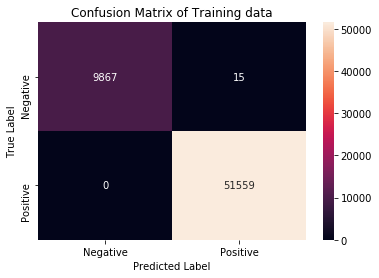

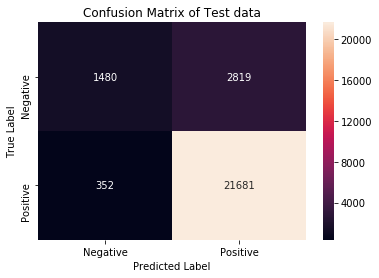

In [ ]:
test_auc_avgw2v, clf_avgw2v = RandomForest_Test(sent_vectors_train, sent_vectors_test, 
                                                best_max_depth_avgw2v, best_base_learner_avgw2v)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best param:  {'max_depth': 20, 'n_estimators': 350}
Best Score:  0.8747279056599092


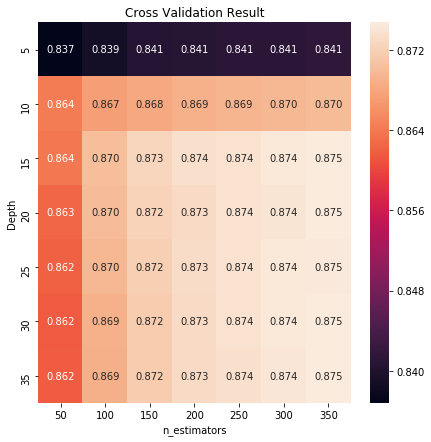

In [ ]:
best_max_depth_tfidfw2v, best_base_learner_tfidfw2v = Get_Hyperparameters(tfidf_sent_vectors_train)

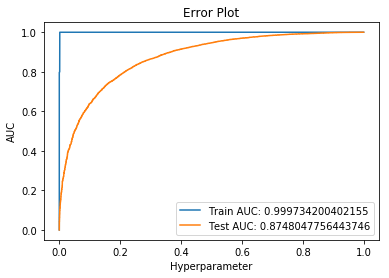

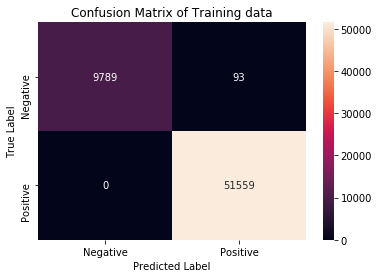

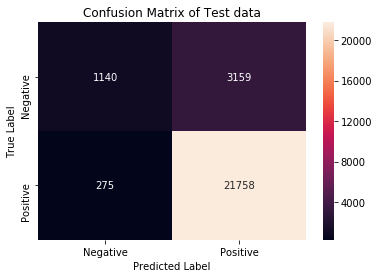

In [ ]:
test_auc_tfidfw2v, clf_tfidfw2v = RandomForest_Test(tfidf_sent_vectors_train, tfidf_sent_vectors_test, 
                                                    best_max_depth_tfidfw2v, best_base_learner_tfidfw2v)

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [38]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
# from sklearn.ensemble import GradientBoostingClassifier

In [39]:
def Get_Hyperparameters_GBDT(X_train_vector):
    max_depth =  [5, 10, 15, 20, 25, 30, 35]
    base_learners =  [50, 100, 150, 200, 250, 300, 350]
    parameters = { 'max_depth' : max_depth, 'n_estimators' : base_learners} 

    clf = XGBClassifier(random_state=0, subsample=0.7, n_jobs=-1)
    grid = GridSearchCV(clf, parameters, cv = 10, scoring='roc_auc')
    grid.fit(X_train_vector, Y_train)

    print("Best Estimator: ", grid.best_estimator_) 
    print("Best param: ", grid.best_params_)
    print("Best Score: ", grid.best_score_)
    
    best_depth = grid.best_params_['max_depth']
    best_base_learner = grid.best_params_['n_estimators']
    
    test_score = grid.cv_results_['mean_test_score'].reshape(len(base_learners), len(max_depth))

    plt.figure(figsize=(8,8))
    sns.heatmap(test_score, annot=True, fmt=".3f", xticklabels=base_learners, yticklabels=max_depth)
    plt.xlabel("n_estimators")
    plt.ylabel("Depth")
    plt.title("Cross Validation Result")
    plt.show()
    return best_depth, best_base_learner

Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=35, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)
Best param:  {'max_depth': 35, 'n_estimators': 350}
Best Score:  0.944460836463861


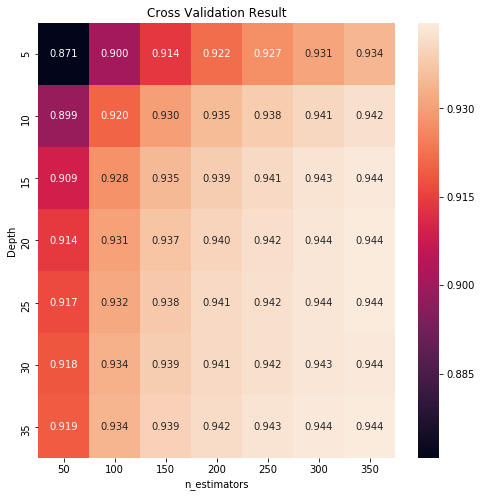

In [ ]:
best_depth_GBDT_bow, best_base_learner_GBDT_bow = Get_Hyperparameters_GBDT(X_train_bow)

In [40]:
def GBDT_Test(X_train_vector, X_test_vector, best_depth, best_base_learner):

    clf = XGBClassifier(n_estimators = best_base_learner, max_depth=best_depth, random_state=0, n_jobs=-1)
    clf.fit(X_train_vector, Y_train)
    
    train_fpr, train_tpr, threshold = roc_curve(Y_train, clf.predict_proba(X_train_vector)[:,1])
    test_fpr, test_tpr, threshold = roc_curve(Y_test, clf.predict_proba(X_test_vector)[:,1])
    
    test_auc=auc(test_fpr,test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC: "+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC: "+str(test_auc))
    
    plt.legend()
    plt.xlabel("Hyperparameter")
    plt.ylabel("AUC")
    plt.title("Error Plot")
    plt.show()
    
    # Plotting confusion matrix to describe the performance of classifier
    # Confusion Matrix of Training data
    class_labels = ['Negative', 'Positive']
    df_cm_train = pd.DataFrame(confusion_matrix(Y_train, clf.predict(X_train_vector)), index=class_labels , columns=class_labels)
    sns.heatmap(df_cm_train, annot=True, fmt="d")
    plt.title("Confusion Matrix of Training data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Confusion Matrix of Training data
    df_cm_test = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test_vector)), index=class_labels , columns=class_labels)
    sns.heatmap(df_cm_test, annot=True, fmt="d")
    plt.title("Confusion Matrix of Test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return test_auc, clf

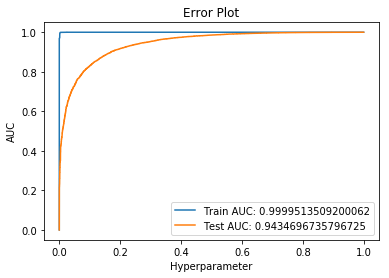

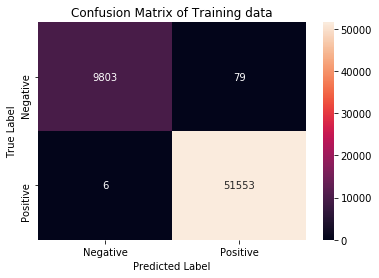

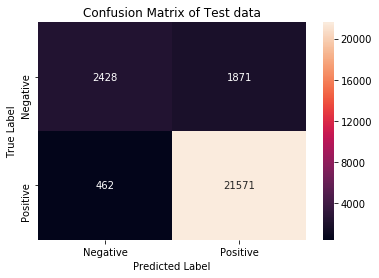

In [ ]:
test_auc_bow_GBDT, clf_bow_GBDT = GBDT_Test(X_train_bow, X_test_bow, 
                                            best_depth_GBDT_bow, best_base_learner_GBDT_bow)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)
Best param:  {'max_depth': 20, 'n_estimators': 350}
Best Score:  0.9521899745958528


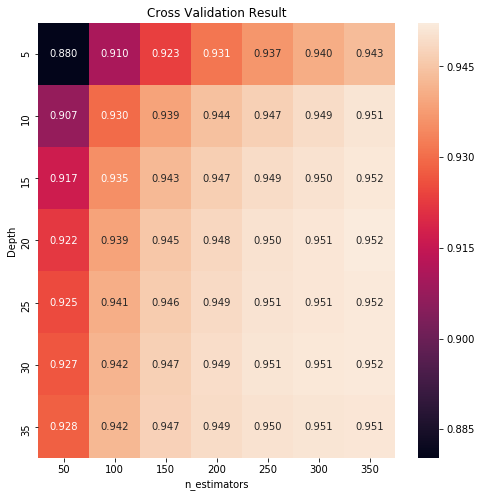

In [ ]:
best_depth_GBDT_tfidf, best_base_learner_GBDT_tfidf = Get_Hyperparameters_GBDT(X_train_tfidf)

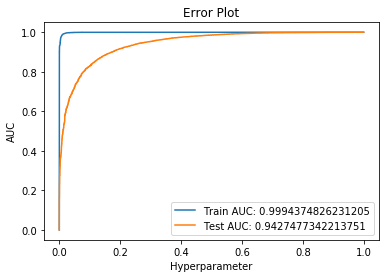

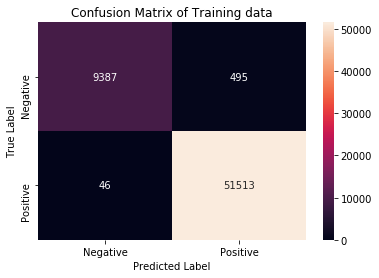

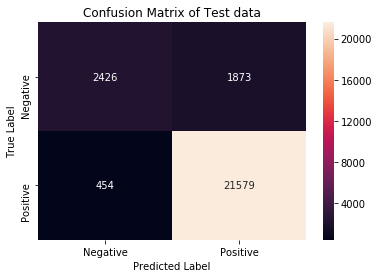

In [ ]:
test_auc_tfidf_GBDT, clf_tfidf_GBDT = GBDT_Test(X_train_bow, X_test_bow, 
                                                best_depth_GBDT_tfidf, best_base_learner_GBDT_tfidf)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)
Best param:  {'max_depth': 25, 'n_estimators': 350}
Best Score:  0.9165140139750995


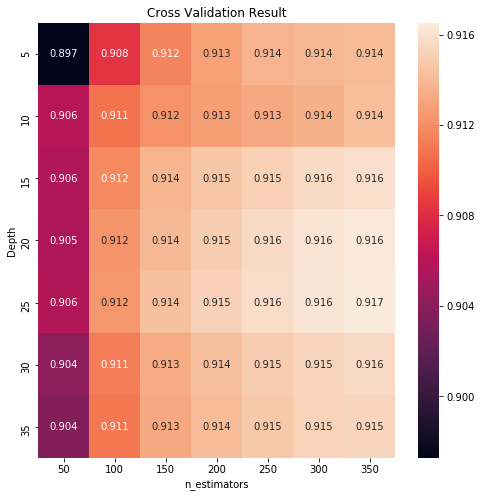

In [41]:
best_depth_GBDT_avgw2v, best_base_learner_GBDT_avgw2v = Get_Hyperparameters_GBDT(np.array(sent_vectors_train))

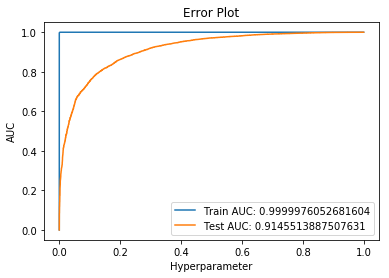

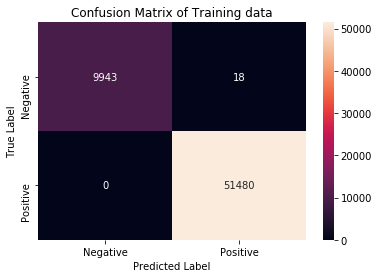

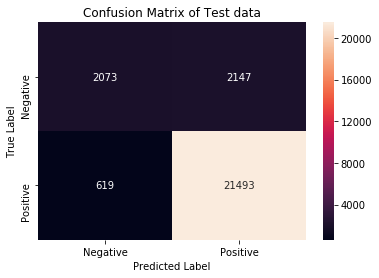

In [42]:
test_auc_avgw2v_GBDT, clf_avgw2v_GBDT = GBDT_Test(np.array(sent_vectors_train), np.array(sent_vectors_test), 
                                                  best_depth_GBDT_avgw2v, best_base_learner_GBDT_avgw2v)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)
Best param:  {'max_depth': 25, 'n_estimators': 350}
Best Score:  0.8979371596236952


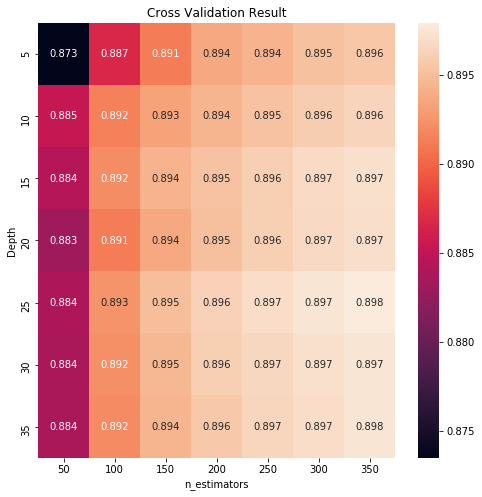

In [43]:
best_depth_GBDT_tfidfw2v, best_base_learner_GBDT_tfidfw2v = Get_Hyperparameters_GBDT(np.array(tfidf_sent_vectors_train))

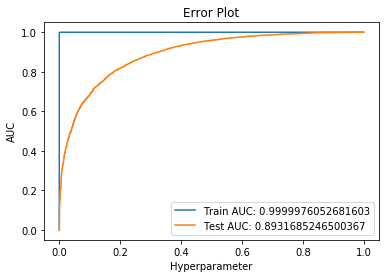

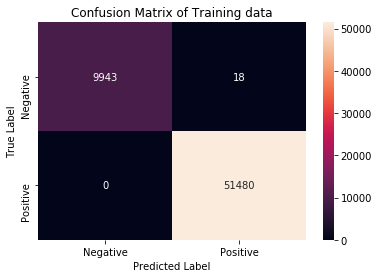

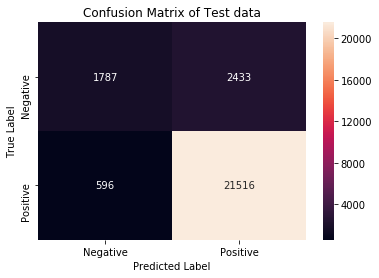

In [44]:
test_auc_tfidfw2v_GBDT, clf_tfidfw2v_GBDT = GBDT_Test(np.array(tfidf_sent_vectors_train), np.array(tfidf_sent_vectors_test), best_depth_GBDT_tfidfw2v,
                                                      best_base_learner_GBDT_tfidfw2v)

# [6] Conclusions

In [46]:
models = pd.DataFrame({
'Vectorizer': ["BOW", "TFIDF", "AVGW2V", "TFIDFW2V", "BOW", "TFIDF", "AVGW2V", "TFIDFW2V"], 
'Model' : ['RandomForest', 'RandomForest', 'RandomForest', 'RandomForest', 'GBDT', 'GBDT', 'GBDT', 'GBDT'],
'Hyper Parameter(Max_Depth, BaseLearners)': [
    {'Depth': best_max_depth_bow, 'BaseLearners': best_base_learner_bow},
    {'Depth': best_max_depth_tfidf, 'BaseLearners': best_base_learner_tfidf},
    {'Depth': best_max_depth_avgw2v, 'BaseLearners': best_base_learner_avgw2v},
    {'Depth': best_max_depth_tfidfw2v, 'BaseLearners': best_base_learner_tfidfw2v},
    {'Depth': best_depth_GBDT_bow, 'BaseLearners': best_base_learner_GBDT_bow},
    {'Depth': best_depth_GBDT_tfidf, 'BaseLearners': best_base_learner_GBDT_tfidf},
    {'Depth': best_depth_GBDT_avgw2v, 'BaseLearners': best_base_learner_GBDT_avgw2v},
    {'Depth': best_depth_GBDT_tfidfw2v, 'BaseLearners': best_base_learner_GBDT_tfidfw2v}], 
'AUC': [test_auc_bow, test_auc_tfidf, test_auc_avgw2v, test_auc_tfidfw2v,
       test_auc_bow_GBDT, test_auc_tfidf_GBDT, test_auc_avgw2v_GBDT, test_auc_tfidfw2v_GBDT]}, 
columns = ["Vectorizer", "Model", "Hyper Parameter(Max_Depth, BaseLearners)", "AUC"])
print(models)

  Vectorizer         Model Hyper Parameter(Max_Depth, BaseLearners)       AUC
0        BOW  RandomForest       {'Depth': 35, 'BaseLearners': 350}  0.901000
1      TFIDF  RandomForest       {'Depth': 35, 'BaseLearners': 350}  0.917000
2     AVGW2V  RandomForest       {'Depth': 30, 'BaseLearners': 350}  0.898000
3   TFIDFW2V  RandomForest       {'Depth': 20, 'BaseLearners': 350}  0.874000
4        BOW          GBDT       {'Depth': 35, 'BaseLearners': 350}  0.943000
5      TFIDF          GBDT       {'Depth': 20, 'BaseLearners': 350}  0.942000
6     AVGW2V          GBDT       {'Depth': 25, 'BaseLearners': 350}  0.914551
7   TFIDFW2V          GBDT       {'Depth': 25, 'BaseLearners': 350}  0.893169


* Done the featurization of reviews using BOW, TFIDF, AVGW2V and TFIDF-W2V
* Created new feature of Review Length
* Define a function to get the optimized hyperparameters for maximum depth and number of base learners for all 4 featurization   using cross-validation with GridSearchCV for both Random Forest (Bagging) and GBDT using XGBoost (Boosting).
* Define a function to plot 3D graph using plotly for hyperparamter and AUC (Train and Test)
* Created HeatMap for AUC using hyperparameter values 
* Define a function to test Random Forest and GBDT on optimized/best hyperparameters for all 4 featurization and visually represent the errors vs hyperparameter plot.
* Used ROC-AUC and Confusion matrix as performance metric
* Calculated top 20 important features for BOW and TFIDF